# <span style="color:#336699">simplecube - An simple python package for creating satellite image data cubes based on Brazil Data Cube </span>
<hr style="border:2px solid #0077b9;">

<div style="text-align: left;">
    <a href="https://nbviewer.jupyter.org/github/brazil-data-cube/code-gallery/"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>

<br/>

<div style="text-align: center;font-size: 90%;">
    Gabriel Sansigolo<sup><a href="https://orcid.org/0000-0003-0789-5858"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    Earth Observation and Geoinformatics Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:gabriel.sansigolo@inpe.br">gabriel.sansigolo@inpe.br</a>
    <br/><br/>
    Last Update: June 15, 2024
</div>

<br/>


In [1]:
#!pip install git+https://github.com/GSansigolo/simplecube
#!pip install git+https://github.com/GSansigolo/wcpms

In [2]:
from simplecube import hls_simple_cube, get_timeseries_datacube
from pyproj import Transformer
import os

In [3]:
path_dir = os.path.abspath("")

In [4]:
cube = hls_simple_cube(
    data_dir=os.path.join(path_dir,'T21JYJ/')
)

cube

<xarray.Dataset> Size: 5GB
Dimensions:      (band: 1, x: 3660, y: 3660, time: 101)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 29kB -3.1e+06 -3.1e+06 ... -3.21e+06 -3.21e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 808B 2024-01-05T13:38:31 ... 2024-12-3...
Data variables:
    band_data    (time, band, y, x) float32 5GB 7.364e+03 ... 3.293e+03

In [5]:
transformer = Transformer.from_crs("EPSG:4326","EPSG:32621")
point = transformer.transform(-54.655961270606149, -28.369646876435905)

point

(2318773.012163887, -6440484.308675966)

In [37]:
ts_ndvi = get_timeseries_datacube(
    cube=cube, 
    geom=[dict(coordinates = [point[0], point[1]])],
)

In [7]:
import matplotlib.pyplot as plt

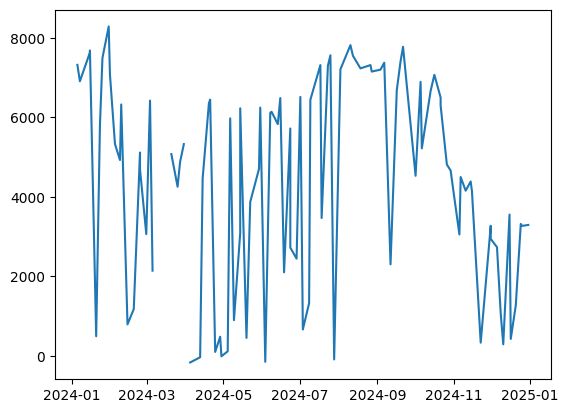

In [8]:
plt.plot(ts_ndvi['timeline'], ts_ndvi['values'])

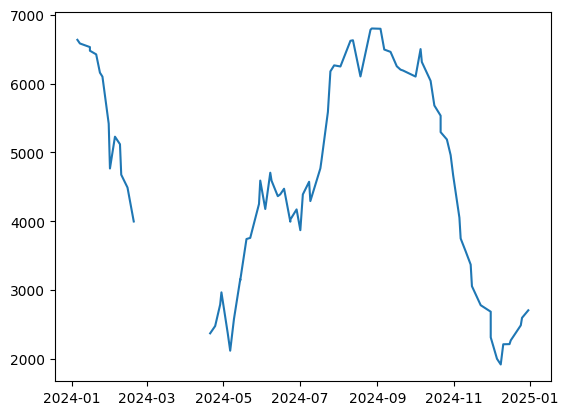

In [9]:
from wcpms_server import smooth_timeseries

plt.plot(ts_ndvi['timeline'], smooth_timeseries(ts_ndvi['values'], method='savitsky', window_length=10))

In [10]:
from wcpms_server import calc_phenometrics, params_phenometrics,wcpms_array

In [18]:
config = params_phenometrics(
    peak_metric='pos', 
    base_metric='vos', 
    method='seasonal_amplitude', 
    factor=0.2, 
    thresh_sides='two_sided', 
    abs_value=0.1,
    date_format='yyyy-mm-dd'
)

In [19]:
ndvi_array = wcpms_array(
    timeserie=smooth_timeseries(ts_ndvi['values'], method='savitsky', window_length=10),
    timeline=cube['time']
)

In [20]:
ds_phenos = calc_phenometrics(
    da=ndvi_array,
    engine='phenolopy',
    config=config,
    start_date='2024-01-05'
)

ds_phenos

{'mos_v': 6321.48193359375,
 'roi_v': 31.946666717529297,
 'rod_v': 46.208045959472656,
 'lios_v': 270865.1875,
 'sios_v': 163350.78125,
 'liot_v': -9999,
 'siot_v': -9999,
 'aos_v': 4881.2001953125,
 'bse_v': 2020.050048828125,
 'los_v': 207.0,
 'sos_v': 2967.5,
 'sos_t': '2024-05-04T00:00:00',
 'pos_v': 6801.10009765625,
 'pos_t': '2024-09-01T00:00:00',
 'vos_v': 1919.9000244140625,
 'vos_t': '2024-12-13T00:00:00',
 'eos_v': 2781.0,
 'eos_t': '2024-11-27T00:00:00'}

In [21]:
ds_phenos['sos_t']

'2024-05-04T00:00:00'

In [22]:
ds_phenos['eos_t']

'2024-11-27T00:00:00'

Text(2024-12-13 00:00:00, 1919.9000244140625, 'VOS')

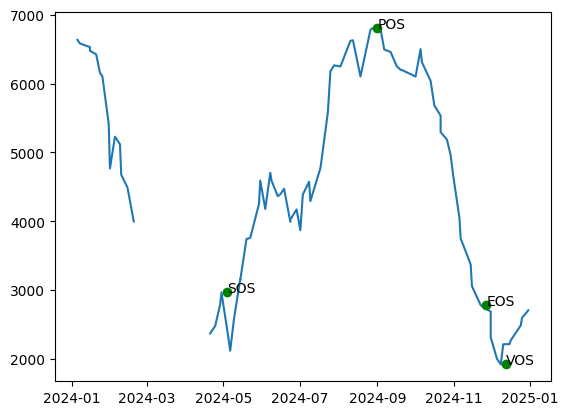

In [35]:
from datetime import datetime

plt.plot(ts_ndvi['timeline'], smooth_timeseries(ts_ndvi['values'], method='savitsky', window_length=10), label='Smooth NDVI') 

p = ds_phenos

sos_time = datetime.strptime(p['sos_t'], '%Y-%m-%dT00:00:00')
plt.plot(sos_time, p['sos_v'], 'go', label='_nolegend_')
plt.annotate('SOS', [sos_time, p['sos_v']])

eos_time = datetime.strptime(p['eos_t'], '%Y-%m-%dT00:00:00')
plt.plot(eos_time, p['eos_v'], 'go', label='_nolegend_')
plt.annotate('EOS', [eos_time, p['eos_v']])

pos_time = datetime.strptime(p['pos_t'], '%Y-%m-%dT00:00:00')
plt.plot(pos_time, p['pos_v'], 'go', label='_nolegend_')
plt.annotate('POS', [pos_time, p['pos_v']])

vos_time = datetime.strptime(p['vos_t'], '%Y-%m-%dT00:00:00')
plt.plot(vos_time, p['vos_v'], 'go', label='_nolegend_')
plt.annotate('VOS', [vos_time, p['vos_v']])
